In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")
import fxcmpy
import yfinance as yf

/var/folders/vt/l70v337s047_p4k5c0kp45200000gn/T/ipykernel_36099/1580071710.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# Bollinger Bands Backtester Class

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")


class BollingerBandsBacktester():
    ''' Class for the vectorized backtesting of Bollinger Bands-based trading strategies.
    '''
    
    def __init__(self, symbol, SMA, dev, start, end, tc,api = None,frequency = 'D1'):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA: int
            moving window in bars (e.g. days) for SMA
        dev: int
            distance for Lower/Upper Bands in Standard Deviation units
        start: str
            start date for data import
        end: str
            end date for data import
        tc: float
            proportional transaction/trading costs per trade
        api: fxcmpy.fxcmpy object
            api object for fxcm data
        frequency: str
            frequency of data
        
        '''
        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.api = api
        self.frequency = frequency
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        rep = "MeanRevBacktester(symbol = {}, SMA = {}, dev = {}, start = {}, end = {})"
        return rep.format(self.symbol, self.SMA, self.dev, self.start, self.end)
        

    def get_data(self):
        ''' Imports the data from FXCM if api is provided else data is imported from yahoo-Finance.
        '''
        if self.api is None:
            raw = yf.download(self.symbol,self.start,self.end).Close.to_frame()
            raw = raw.rename(columns={'Close':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw
        else:
            raw = self.api.get_candles(self.symbol, start = self.start, end = self.end, period = self.frequency)
            raw = raw['askclose'].to_frame()
            raw = raw.rename(columns={'askclose':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw

        
    def prepare_data(self):
        '''Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data["SMA"] = data["price"].rolling(self.SMA).mean()
        data["Lower"] = data["SMA"] - data["price"].rolling(self.SMA).std() * self.dev
        data["Upper"] = data["SMA"] + data["price"].rolling(self.SMA).std() * self.dev
        self.data = data
        
    def set_parameters(self, SMA = None, dev = None):
        ''' Updates parameters (SMA, dev) and the prepared dataset.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean()
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
    def test_strategy(self):
        ''' Backtests the Bollinger Bands-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower, 1, np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA = {} | dev = {} | TC = {}".format(self.symbol, self.SMA, self.dev, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))     
   
    def optimize_parameters(self, SMA_range, dev_range):
        ''' Finds the optimal strategy (global maximum) given the Bollinger Bands parameter ranges.

        Parameters
        ----------
        SMA_range, dev_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        combinations = list(product(range(*SMA_range), range(*dev_range)))
        
        # test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA", "dev"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf
    

/var/folders/vt/l70v337s047_p4k5c0kp45200000gn/T/ipykernel_36099/2329113416.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [3]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

In [28]:
tester = BollingerBandsBacktester("EUR/USD", 86, 2, "2018-01-01", "2019-12-31", 0.0,api,'H2')

In [29]:
tester

MeanRevBacktester(symbol = EUR/USD, SMA = 86, dev = 2, start = 2018-01-01, end = 2019-12-31)

In [30]:
tester.test_strategy()

(1.106405, 0.169474)

In [31]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
date,,,,,,,,,,,
2018-01-10 20:00:00,1.19489,-0.000786,1.201153,1.191771,1.210534,-0.006263,0.0,-0.000000,0.0,0.999214,1.000000
2018-01-10 22:00:00,1.19567,0.000653,1.201085,1.191629,1.210540,-0.005415,0.0,0.000000,0.0,0.999866,1.000000
2018-01-11 00:00:00,1.19599,0.000268,1.201025,1.191506,1.210544,-0.005035,0.0,0.000000,0.0,1.000134,1.000000
2018-01-11 02:00:00,1.19543,-0.000468,1.200951,1.191357,1.210544,-0.005521,0.0,-0.000000,0.0,0.999666,1.000000
2018-01-11 04:00:00,1.19529,-0.000117,1.200866,1.191202,1.210530,-0.005576,0.0,-0.000000,0.0,0.999548,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 16:00:00,1.12112,0.000866,1.111910,1.104205,1.119615,0.009210,-1.0,-0.000866,0.0,0.937525,1.105704
2019-12-30 18:00:00,1.12027,-0.000758,1.111996,1.104085,1.119907,0.008274,-1.0,0.000758,0.0,0.936814,1.106543
2019-12-30 20:00:00,1.11994,-0.000295,1.112091,1.103996,1.120185,0.007849,-1.0,0.000295,0.0,0.936538,1.106869


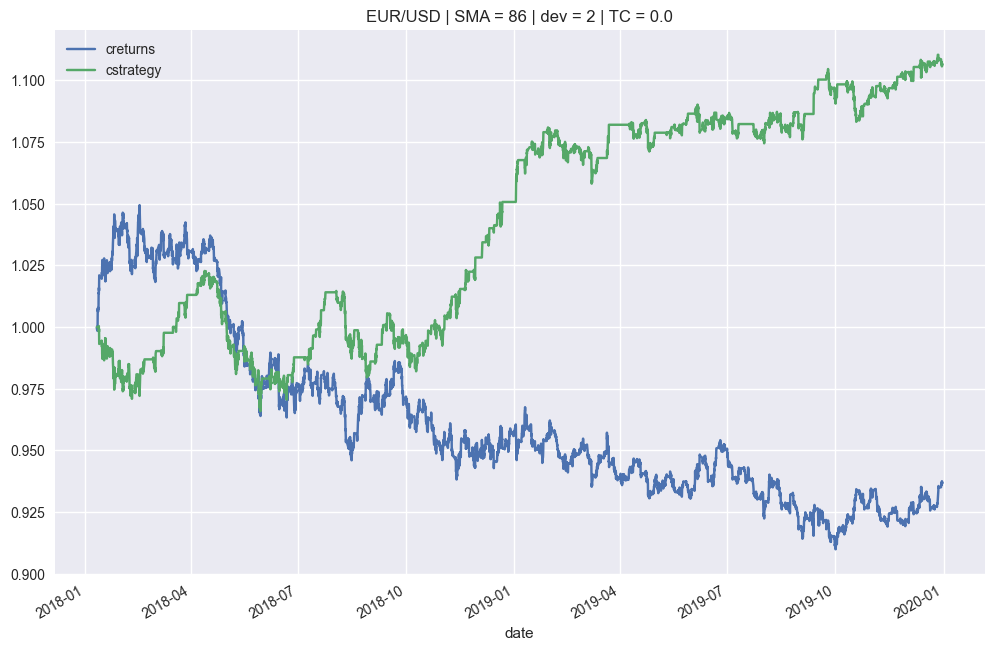

In [32]:
tester.plot_results()

In [27]:
tester.optimize_parameters((25, 100, 1), (1, 5, 1))

((86, 2), 1.106405)

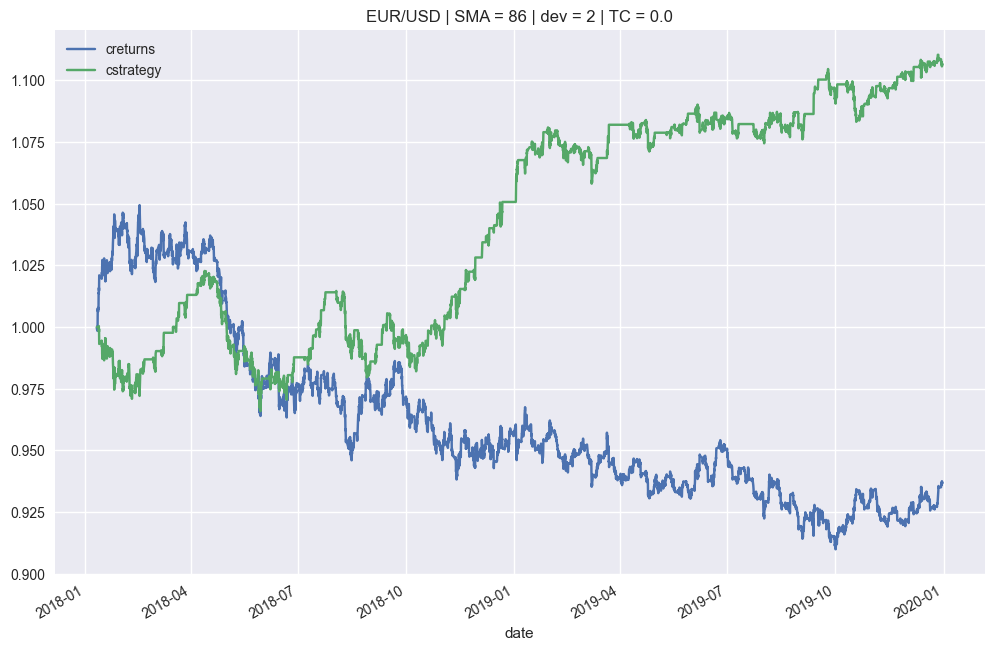

In [33]:
tester.plot_results()

In [34]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
date,,,,,,,,,,,
2018-01-10 20:00:00,1.19489,-0.000786,1.201153,1.191771,1.210534,-0.006263,0.0,-0.000000,0.0,0.999214,1.000000
2018-01-10 22:00:00,1.19567,0.000653,1.201085,1.191629,1.210540,-0.005415,0.0,0.000000,0.0,0.999866,1.000000
2018-01-11 00:00:00,1.19599,0.000268,1.201025,1.191506,1.210544,-0.005035,0.0,0.000000,0.0,1.000134,1.000000
2018-01-11 02:00:00,1.19543,-0.000468,1.200951,1.191357,1.210544,-0.005521,0.0,-0.000000,0.0,0.999666,1.000000
2018-01-11 04:00:00,1.19529,-0.000117,1.200866,1.191202,1.210530,-0.005576,0.0,-0.000000,0.0,0.999548,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 16:00:00,1.12112,0.000866,1.111910,1.104205,1.119615,0.009210,-1.0,-0.000866,0.0,0.937525,1.105704
2019-12-30 18:00:00,1.12027,-0.000758,1.111996,1.104085,1.119907,0.008274,-1.0,0.000758,0.0,0.936814,1.106543
2019-12-30 20:00:00,1.11994,-0.000295,1.112091,1.103996,1.120185,0.007849,-1.0,0.000295,0.0,0.936538,1.106869
